In [102]:
from math import sin, cos, tan
from cmath import exp
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
import pandas as pd
from matplotlib.patches import Rectangle
from Torch_functions import *
from Numpy_functions import *
%matplotlib inline

# Data Generation

In [3]:
N_layers=12
d_max=350
n1=1.45
n2=2.08
training_structure=np.zeros((N_layers+2,2),dtype=float)
d=np.random.randint(0,high=d_max,size=N_layers+1)

for i in range(1,N_layers+1,2):
    training_structure[i,0]=n1
    training_structure[i,1]=d[i-1]
    training_structure[i+1,0]=n2
    training_structure[i+1,1]=d[i]
training_structure[0,0]=1
training_structure[N_layers+1,0]=1.52
#training_structure[0,0]=1.52
#training_structure[N_layers+1,0]=1
training_structure[0,1]=training_structure[N_layers+1,1]=0

In [4]:
print(training_structure)

[[  1.     0.  ]
 [  1.45  97.  ]
 [  2.08  89.  ]
 [  1.45 340.  ]
 [  2.08 125.  ]
 [  1.45 280.  ]
 [  2.08 293.  ]
 [  1.45 202.  ]
 [  2.08 164.  ]
 [  1.45   1.  ]
 [  2.08  37.  ]
 [  1.45 141.  ]
 [  2.08 303.  ]
 [  1.52   0.  ]]


In [5]:
def numpy_N_for_all_angles(n_structure,wl=780, angle_start=20, angle_stop=30, points=20):
    angles=np.linspace(angle_start,angle_stop,points)
    N=np.zeros((len(angles),len(n_structure)),dtype=np.complex)
    for ind,angle in enumerate(angles):
        N[ind]=(n_structure ** 2 - n_structure[0] ** 2 * (sin(angle/180*np.pi)) ** 2) ** 0.5
    return N

def numpy_create_tm_all_angles(N):
    a=(N[:,1:]+N[:,:-1])/(2.*N[:,1:])
    b=(N[:,1:]-N[:,:-1])/(2.*N[:,1:])
    t=np.zeros((a.shape[0],a.shape[1],2,2),dtype=np.complex)
    t[:,:,0,0]=t[:,:,1,1]=a
    t[:,:,0,1]=t[:,:,1,0]=b
    return t
               
def numpy_phase_all_angles(d,N,k0):
    d=d[:,None,:]
    phase=np.zeros((d.shape[0],N.shape[0],d.shape[2],2,2),dtype=np.complex)
    phase[:,:,:,0,0]=np.exp(1.j * N[:,1:-1]*d * k0)
    phase[:,:,:,1,1]=np.exp(-1.j * N[:,1:-1]*d * k0)  
    return phase
               

def numpy_R_for_all_angles(phase,transfer): 
    
    Total_transfer_matrix = np.zeros((phase.shape[0],phase.shape[1],2,2),dtype=np.complex)
    Total_transfer_matrix[:,:,0,0]=Total_transfer_matrix[:,:,1,1]=1    
    for i in range(phase.shape[2]):        
        Total_transfer_matrix = np.matmul(transfer[None,:,i], Total_transfer_matrix)
        Total_transfer_matrix = np.matmul(phase[:,:,i], Total_transfer_matrix)        
    Total_transfer_matrix = np.matmul(transfer[None,:,-1], Total_transfer_matrix)
    return -(Total_transfer_matrix[:,:,1, 0] / Total_transfer_matrix[:,:,1, 1])

In [55]:
n_samples=40000
min_sample_number=0
angle_min=0
angle_max=40
points=100

thicknes=np.random.randint(0,high=d_max,size=(n_samples,N_layers))

Sample_n_per_cycle=20000
sample_numbers=np.arange(0,stop=n_samples, step=Sample_n_per_cycle)
N_all=numpy_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)

training_type="real+imag"
training_type="abs"

if training_type=="real+imag":
    refl=np.zeros((n_samples,2*points),dtype=float)
else:
    refl=np.zeros((n_samples,points),dtype=float)

for number in sample_numbers:
    print(number)
    phase=numpy_phase_all_angles(thicknes[number:number+Sample_n_per_cycle],N_all,2*np.pi/780)
    total_matrix=numpy_R_for_all_angles(phase,transfer)
    if training_type=="real+imag":
        refl[number:number+Sample_n_per_cycle,:points]=np.real(total_matrix)
        refl[number:number+Sample_n_per_cycle,points:]=np.imag(total_matrix)
    else:
        refl[number:number+Sample_n_per_cycle]=np.abs(total_matrix)

0
20000


# Data loading

In [2]:
file_name='10layers_angle'
test_structures=np.loadtxt('test/test_thicknes_'+file_name+'.csv',delimiter=',',dtype=float)
refl_test_pd=pd.read_csv('test/test_R_'+file_name+'.csv',delimiter=',',header=None,skiprows=6)
refl_test=refl_test_pd.to_numpy()

In [3]:
with open('test/test_thicknes_'+file_name+'.csv') as f:
    f.readline()
    structure=f.readline()
    max_thick_nm=f.readline()
n_structure=np.fromstring(structure[4:-3], dtype=float, sep=' ')
d_max=int(max_thick_nm[-5:])
with open('test/test_R_'+file_name+'.csv') as f:
    f.readline()
    f.readline()
    ang_str=f.readline()
    wl=int(f.readline()[18:21])
    points_str=f.readline()
angle_min=int(ang_str[17:-7])
angle_max=int(ang_str[21:-2])
points=int(points_str[20:-1])
print(f"Array of layer indices:\n {n_structure} \n Maximal thickness of layer: {d_max} nm\n \
Angle range: {angle_min} - {angle_max}\n Wavelength: {wl} nm\n Number of discretezation points: {points}")
angles=np.linspace(angle_min, angle_max, points)
wavevector=2*np.pi/wl

Array of layer indices:
 [1.   1.45 2.08 1.45 2.08 1.45 2.08 1.45 2.08 1.45 2.08 1.52] 
 Maximal thickness of layer: 350 nm
 Angle range: 0 - 40
 Wavelength: 800 nm
 Number of discretezation points: 100


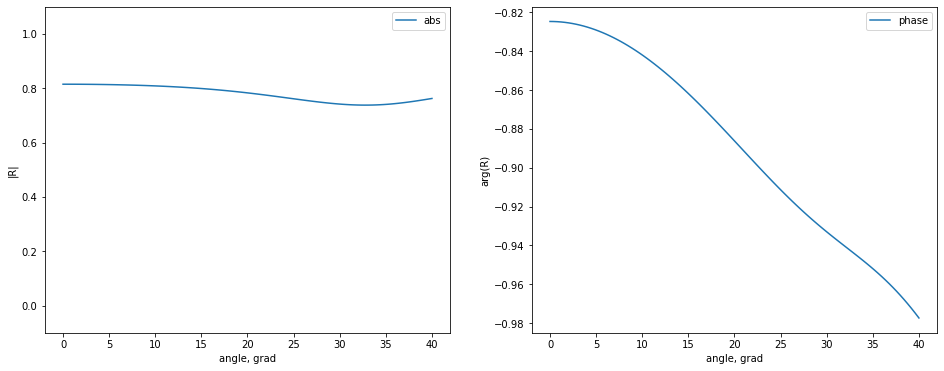

In [4]:
number=1900
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_test[number,:points]**2+refl_test[number,points:]**2), label="abs")
plt.xlabel("angle, grad")
plt.ylabel("|R|")
plt.ylim(top=1.1, bottom=-0.1)
plt.legend()
plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_test[number,points:],refl_test[number,:points])/np.pi, label="phase")
plt.xlabel("angle, grad")
plt.ylabel("arg(R)")
plt.legend()
plt.show()

# Torch functions

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

class Back_Net(nn.Module):
    
    def __init__(self, inputs, outputs, hidden_layers):
        super(Back_Net, self).__init__()
        current_dim = inputs
        self.layers = nn.ModuleList()
        for hdim in hidden_layers:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, outputs))
        
    def forward(self,x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return torch.sigmoid(self.layers[-1](x))

# Data preparation and model loading

In [6]:
Spectrum=(refl_test)

Spectrum=torch.FloatTensor(Spectrum)
train_dataset=TensorDataset(Spectrum)

print(Spectrum.shape)

torch.Size([40000, 200])


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model=torch.load("trained_models/PC12_layers_400K_0-40.pth",map_location=torch.device('cpu'))
#model=torch.load("trained_models/angles/PC_10layers_30000samples_0-40_0.01042.pth",map_location=device)
file='PC_10layers_100000samples_0-40_9.2643e-05'
model=torch.load("trained_models/angles/"+file+".pth",map_location=device)

model

Back_Net(
  (layers): ModuleList(
    (0): Linear(in_features=200, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [8]:
loss_history=np.loadtxt("trained_models/angles/"+file+".txt")

In [9]:
angles=np.linspace(angle_min,angle_max,points)
thick_pred=model.forward(Spectrum)
thick_pred=thick_pred.detach().numpy()*d_max


N_all=create_N_for_all_angles(n_structure,wl=wl, angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)

phase=numpy_phase_all_angles(thick_pred,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

training_type="real+imag"
if training_type=="real+imag":
    refl_pred=np.zeros((Spectrum.size(0),2*points),dtype=float)
    refl_pred[:,:points]=np.real(total_matrix)
    refl_pred[:,points:]=np.imag(total_matrix)
else:
    refl_pred=np.zeros((Spectrum.size(0),points),dtype=float)
    refl_pred=np.abs(total_matrix)

In [10]:
MSE=np.mean((refl_test-refl_pred)**2,axis=1)

In [11]:
print(f'MSE={MSE.mean()}')

MSE=0.00012883731217352068


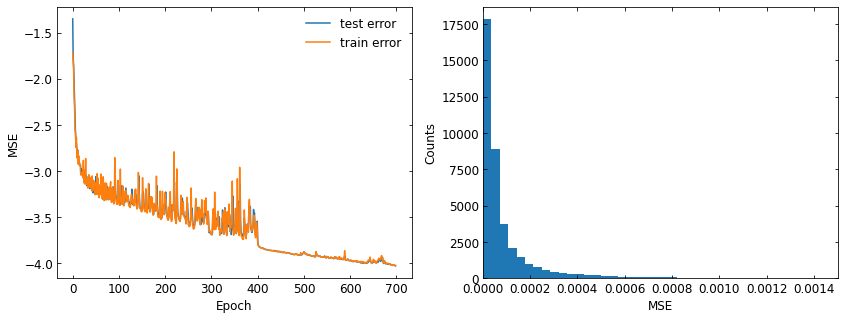

In [27]:
fontsize=12
fig=plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(np.log10(loss_history[:,1]), label='test error')
plt.plot(np.log10(loss_history[:,0]), label='train error')

plt.xlabel('Epoch',fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
#plt.xlim(left=0)
#plt.ylim(bottom=-0.002)
plt.legend(frameon=False,fontsize=fontsize)

plt.subplot(1,2,2)
plt.hist(MSE, bins=1000)
plt.xlim(left=0,right=0.0015)
plt.xlabel('MSE', fontsize=fontsize)
plt.ylabel('Counts', fontsize=fontsize)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)

directory='/Users/kirillsafronov/Documents/Lab/tex/Inverse_design_JETP/'
plt.savefig(directory+file+'_error.png', dpi=400, bbox_inches='tight')
plt.show()

In [28]:
loss=nn.MSELoss()
N_all=create_N_for_all_angles(n_structure,wl=wl, angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=create_transfer_matrix_all_angles(N_all)
N=torch.tensor(np.real(N_all),device=device)
with torch.no_grad():
    model.eval()
    test_preds = model.forward(Spectrum)
    result=loss(R_for_batch(test_preds*d_max,N,transfer,wl=780, points=points), Spectrum)
print("Loss=",result.item())

Loss= 0.00012883733143098652


In [29]:
refl_test_amplitude=np.sqrt(refl_test[:,:points]**2+refl_test[:,points:]**2)

In [30]:
refl_test_amplitude.max(axis=1).shape

(40000,)

In [31]:
sorted_ind=np.argsort(refl_test_amplitude.max(axis=1)-refl_test_amplitude.min(axis=1))

In [87]:
alpha=2.95
beta=0.0
theta_0=20*np.pi/180
test_func=-alpha*1.j*(np.sin(angles*np.pi/180)-np.sin(theta_0))+beta

[228.0551   115.887726 156.4844   150.77306  275.7812   151.07718
 188.3604   257.55188  205.6395   123.339134]
[249. 282. 223.  85.  98. 158. 198.  57. 250. 242.]


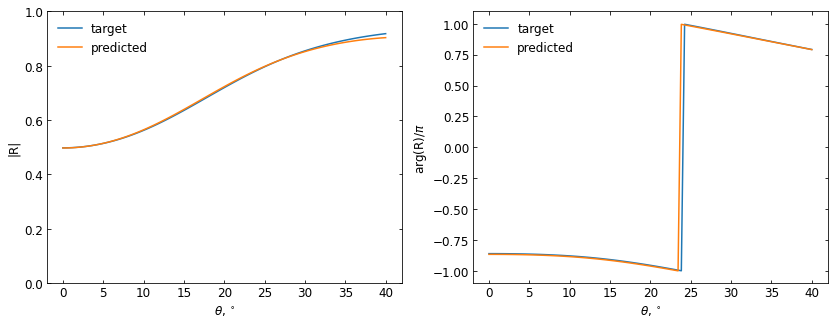

In [99]:
number=2705
#-10
#number=sorted_ind[-10]
print(thick_pred[number])
print(test_structures[number])
fig=plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_test[number,:points]**2+refl_test[number,points:]**2), label="target")
plt.plot(angles, np.sqrt(refl_pred[number,:points]**2+refl_pred[number,points:]**2), label="predicted", color='tab:orange')
#plt.plot(angles, np.abs(test_func),label="perfect diff", color='tab:red')
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("|R|",fontsize=fontsize)
plt.ylim(bottom=0, top=1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.legend(frameon=False,fontsize=fontsize)

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_test[number,points:],refl_test[number,:points])/np.pi, label="target")
plt.plot(angles, np.arctan2(refl_pred[number,points:],refl_pred[number,:points])/np.pi, label="predicted", color='tab:orange')
#plt.plot(angles, np.angle(test_func)/np.pi,label="perfect diff", color='tab:red')
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("arg(R)/$\pi$",fontsize=fontsize)
plt.ylim(bottom=-1.1, top=1.1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.legend(frameon=False,fontsize=fontsize)
#plt.savefig(directory+file+'_diff_abs.png', dpi=400, bbox_inches='tight')

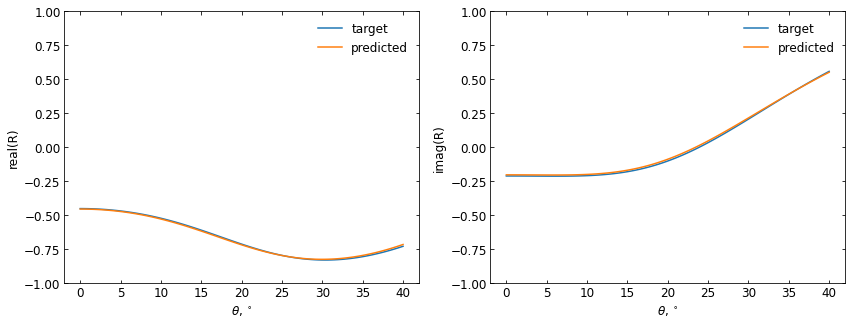

In [39]:
fig=plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(angles, refl_test[number,:points], label="target")
plt.plot(angles, refl_pred[number,:points], label="predicted")
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("real(R)",fontsize=fontsize)
plt.ylim(bottom=-1, top=1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.legend(frameon=False,fontsize=fontsize)

plt.subplot(1,2,2)
plt.plot(angles, refl_test[number,points:], label="target")
plt.plot(angles, refl_pred[number,points:], label="predicted")
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("imag(R)",fontsize=fontsize)
plt.ylim(bottom=-1, top=1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.legend(frameon=False,fontsize=fontsize)
plt.savefig(directory+file+'_test_real.png', dpi=400, bbox_inches='tight')

[244.33438 136.3824  152.52577 120.20169 249.71965 203.9499  240.35815
  98.51951 119.62587 125.5716 ]
[272. 338. 119.  61. 293.  90. 208.  60. 206. 108.]


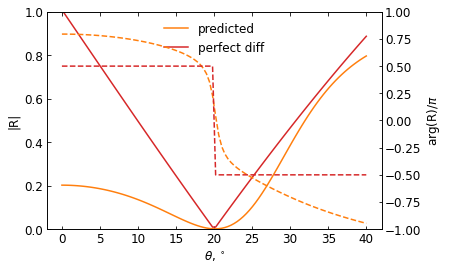

In [127]:
#number=2705
#-10
number=sorted_ind[-10]
print(thick_pred[number])
print(test_structures[number])


#plt.subplot(1,2,1)
#plt.plot(angles, np.sqrt(refl_test[number,:points]**2+refl_test[number,points:]**2), label="target")
plt.plot(angles, np.sqrt(refl_pred[number,:points]**2+refl_pred[number,points:]**2)**2, label="predicted", color='tab:orange')
plt.plot(angles, np.abs(test_func),label="perfect diff", color='tab:red')
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("|R|",fontsize=fontsize)
plt.ylim(bottom=0, top=1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.legend(frameon=False,fontsize=fontsize)

ax2=plt.gca().twinx()
#plt.subplot(1,2,2)
#plt.plot(angles, np.arctan2(refl_test[number,points:],refl_test[number,:points])/np.pi, label="target")
ax2.plot(angles, np.arctan2(refl_pred[number,points:],refl_pred[number,:points])/np.pi,ls='--', label="predicted", color='tab:orange')
ax2.plot(angles, np.angle(test_func)/np.pi,label="perfect diff",ls='--', color='tab:red')
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("arg(R)/$\pi$",fontsize=fontsize)
plt.ylim(bottom=-1, top=1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
#plt.legend(frameon=False,fontsize=fontsize)
#plt.savefig(directory+file+'_diff_full.png', dpi=400, bbox_inches='tight')

In [96]:
target_diff_refl=np.hstack([np.real(test_func), np.imag(test_func)])

In [97]:
np.mean((target_diff_refl-refl_pred[number])**2)

0.13474452466912187

# Var samples

In [8]:
model_20K=torch.load("var_samples/20K.pth",map_location=torch.device('cpu'))
model_40K=torch.load("var_samples/40K.pth",map_location=torch.device('cpu'))
model_80K=torch.load("var_samples/80K.pth",map_location=torch.device('cpu'))
model_200K=torch.load("var_samples/200K.pth",map_location=torch.device('cpu'))
model_400K=torch.load("var_samples/400K.pth",map_location=torch.device('cpu'))
model_40K

Back_Net(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=12, bias=True)
  )
)

In [9]:
error_20K=np.loadtxt("var_samples/20K.txt")
error_40K=np.loadtxt("var_samples/40K.txt")
error_80K=np.loadtxt("var_samples/80K.txt")
error_200K=np.loadtxt("var_samples/200K.txt")
error_400K=np.loadtxt("var_samples/400K.txt")

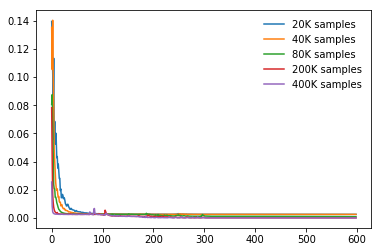

In [37]:
directory="D:/Lab/tex/Inverse design/pictures/"
plt.plot(error_20K[:,0], label="20K samples")
plt.plot(error_40K[:,0], label="40K samples")
plt.plot(error_80K[:,0], label="80K samples")
plt.plot(error_200K[:,0], label="200K samples")
plt.plot(error_400K[:,0], label="400K samples")
plt.legend(frameon=False)
plt.savefig(directory+"12layerPC_6layerNN_a20-30.png",dpi=600)

In [13]:
min_error=np.array([error_20K[:,0].min(),error_40K[:,0].min(),error_80K[:,0].min(),error_200K[:,0].min(),
                   error_400K[:,0].min()])
min_error

array([2.59459578e-03, 2.58503458e-03, 9.23145504e-04, 1.24734550e-04,
       7.64029828e-05])

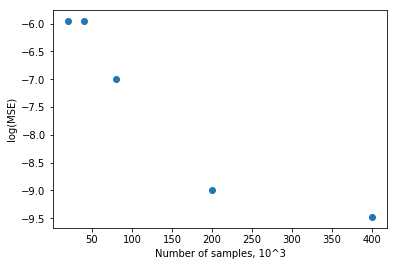

In [38]:
plt.scatter(np.array([20,40,80,200,400]),np.log(min_error))
plt.xlabel("Number of samples, 10^3")
plt.ylabel("log(MSE)")
plt.savefig(directory+"12layerPC_6layerNN_a20-30_error.png",dpi=600)

In [15]:
angle_min=20
angle_max=30
d_max=350
points=int(model_20K.layers[0].in_features/2)
points

20

In [16]:
angles=np.linspace(angle_min,angle_max,points)
thick_20K=model_20K(Spectrum)
thick_20K=thick_20K.detach().numpy()*d_max
r_20K=np.zeros((Spectrum.size(0),2*points),dtype=float)

thick_40K=model_40K(Spectrum)
thick_40K=thick_40K.detach().numpy()*d_max
r_40K=np.zeros((Spectrum.size(0),2*points),dtype=float)

thick_80K=model_80K(Spectrum)
thick_80K=thick_80K.detach().numpy()*d_max
r_80K=np.zeros((Spectrum.size(0),2*points),dtype=float)

thick_200K=model_200K(Spectrum)
thick_200K=thick_200K.detach().numpy()*d_max
r_200K=np.zeros((Spectrum.size(0),2*points),dtype=float)

thick_400K=model_400K(Spectrum)
thick_400K=thick_400K.detach().numpy()*d_max
r_400K=np.zeros((Spectrum.size(0),2*points),dtype=float)

N_all=create_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)

phase_20K=numpy_phase_all_angles(thick_20K,N_all,2*np.pi/780)
total_matrix_20K=numpy_R_for_all_angles(phase_20K,transfer)
r_20K[:,:points]=np.real(total_matrix_20K)
r_20K[:,points:]=np.imag(total_matrix_20K)

phase_40K=numpy_phase_all_angles(thick_40K,N_all,2*np.pi/780)
total_matrix_40K=numpy_R_for_all_angles(phase_40K,transfer)
r_40K[:,:points]=np.real(total_matrix_40K)
r_40K[:,points:]=np.imag(total_matrix_40K)

phase_80K=numpy_phase_all_angles(thick_80K,N_all,2*np.pi/780)
total_matrix_80K=numpy_R_for_all_angles(phase_80K,transfer)
r_80K[:,:points]=np.real(total_matrix_80K)
r_80K[:,points:]=np.imag(total_matrix_80K)

phase_200K=numpy_phase_all_angles(thick_200K,N_all,2*np.pi/780)
total_matrix_200K=numpy_R_for_all_angles(phase_200K,transfer)
r_200K[:,:points]=np.real(total_matrix_200K)
r_200K[:,points:]=np.imag(total_matrix_200K)

phase_400K=numpy_phase_all_angles(thick_400K,N_all,2*np.pi/780)
total_matrix_400K=numpy_R_for_all_angles(phase_400K,transfer)
r_400K[:,:points]=np.real(total_matrix_400K)
r_400K[:,points:]=np.imag(total_matrix_400K)

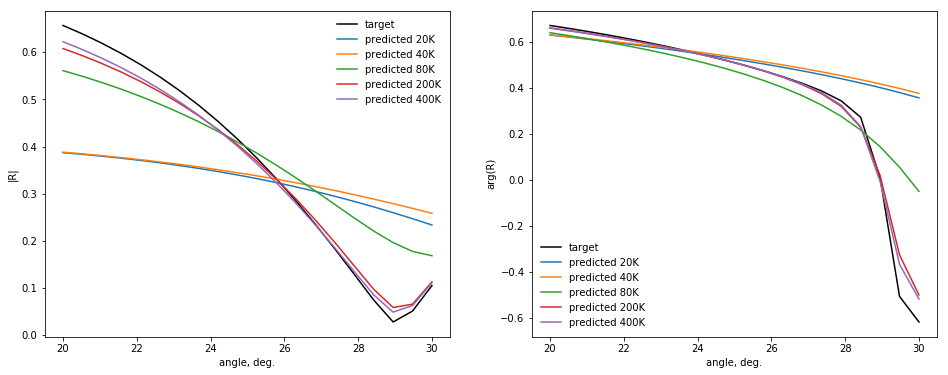

In [39]:
number=13680
fig=plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl[number,:points]**2+refl[number,points:]**2), label="target", color="black")
plt.plot(angles, np.sqrt(r_20K[number,:points]**2+r_20K[number,points:]**2), label="predicted 20K")
plt.plot(angles, np.sqrt(r_40K[number,:points]**2+r_40K[number,points:]**2), label="predicted 40K")
plt.plot(angles, np.sqrt(r_80K[number,:points]**2+r_80K[number,points:]**2), label="predicted 80K")
plt.plot(angles, np.sqrt(r_200K[number,:points]**2+r_200K[number,points:]**2), label="predicted 200K")
plt.plot(angles, np.sqrt(r_400K[number,:points]**2+r_400K[number,points:]**2), label="predicted 400K")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
#plt.ylim(bottom=0, top=1)
plt.legend(frameon=False)

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl[number,points:],refl[number,:points])/np.pi, label="target", color="black")
plt.plot(angles, np.arctan2(r_20K[number,points:],r_20K[number,:points])/np.pi, label="predicted 20K")
plt.plot(angles, np.arctan2(r_40K[number,points:],r_40K[number,:points])/np.pi, label="predicted 40K")
plt.plot(angles, np.arctan2(r_80K[number,points:],r_80K[number,:points])/np.pi, label="predicted 80K")
plt.plot(angles, np.arctan2(r_200K[number,points:],r_200K[number,:points])/np.pi, label="predicted 200K")
plt.plot(angles, np.arctan2(r_400K[number,points:],r_400K[number,:points])/np.pi, label="predicted 400K")
plt.xlabel("angle, deg.")
plt.ylabel("arg(R)")
plt.legend(frameon=False)
plt.savefig(directory+"12layerPC_6layerNN_a20-30_example.png",dpi=600)

In [17]:
R_abs=np.sqrt(refl[:,:points]**2+refl[:,points:]**2)
R_ampl=R_abs.max(axis=1)-R_abs.min(axis=1)
indices_of_largest=np.argsort(R_ampl)[::-1]

In [18]:
indices_of_largest[:10]

array([ 9555, 35252,  8660, 29955, 28090,  1891,  3440, 15429, 20384,
       29351], dtype=int64)

In [61]:
R_arg=np.arctan2(refl[:,points:],refl[:,:points])/np.pi
R_arg_ampl=R_arg.max(axis=1)-R_arg.min(axis=1)
indices_of_largest_arg=np.argsort(R_arg_ampl)[::-1]

In [62]:
indices_of_largest_arg[:10]

array([ 274,  930,  288,  743, 1872, 1603, 1730,  854, 1195, 1693],
      dtype=int64)

Sample number: 9555


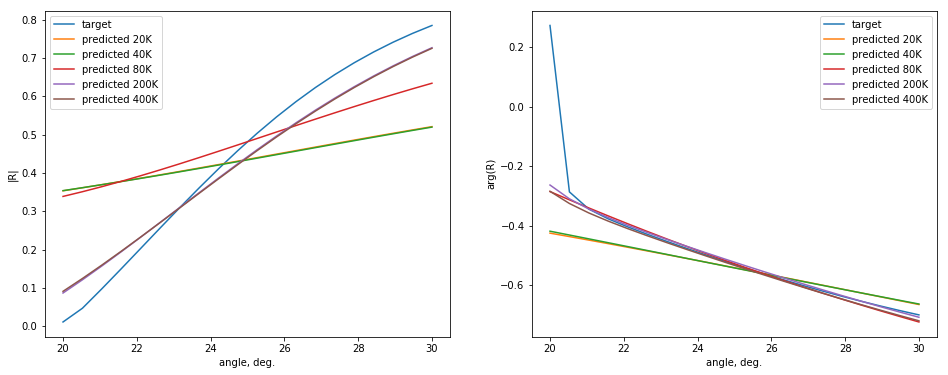

Sample number: 35252


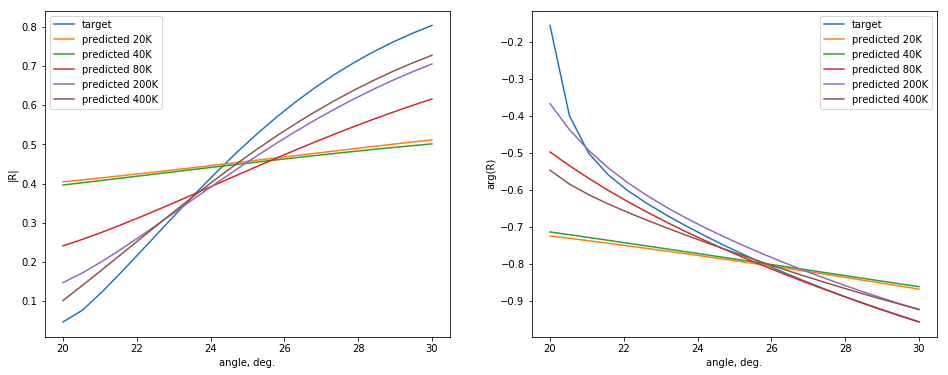

Sample number: 8660


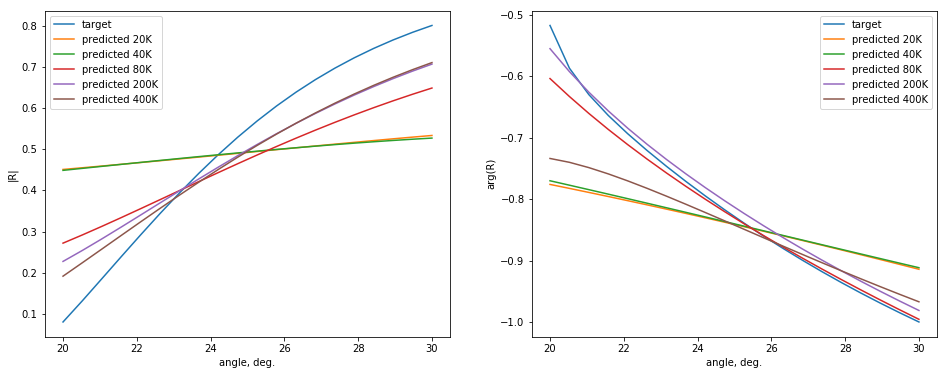

Sample number: 29955


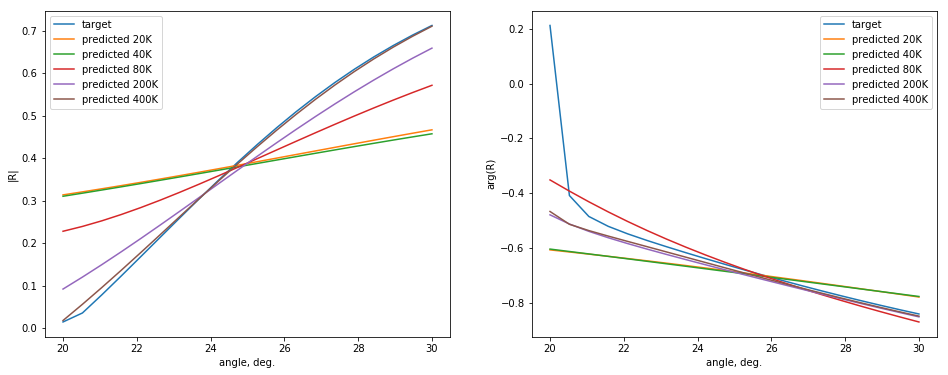

Sample number: 28090


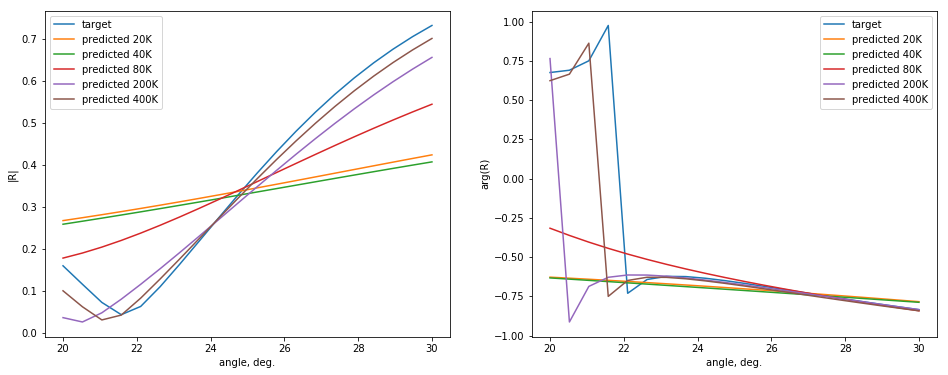

Sample number: 1891


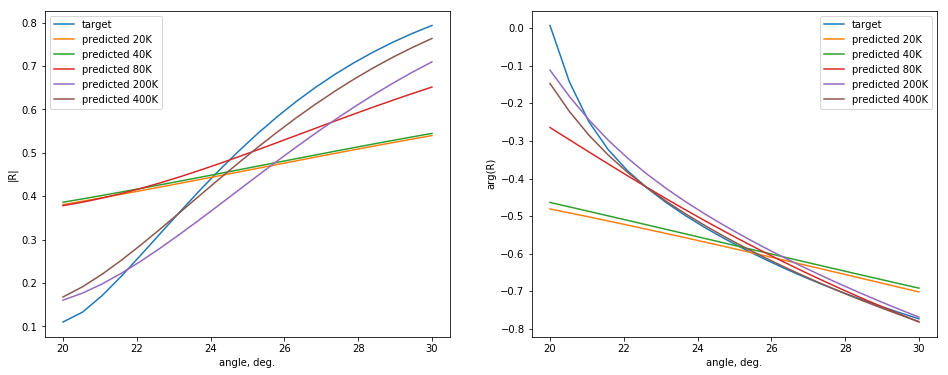

Sample number: 3440


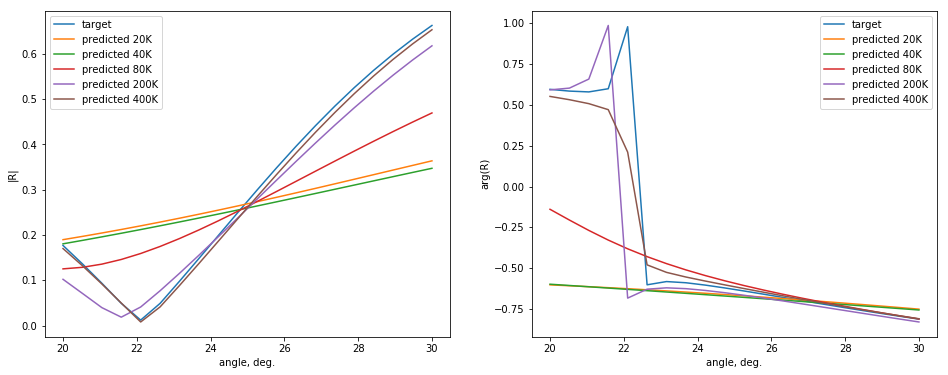

Sample number: 15429


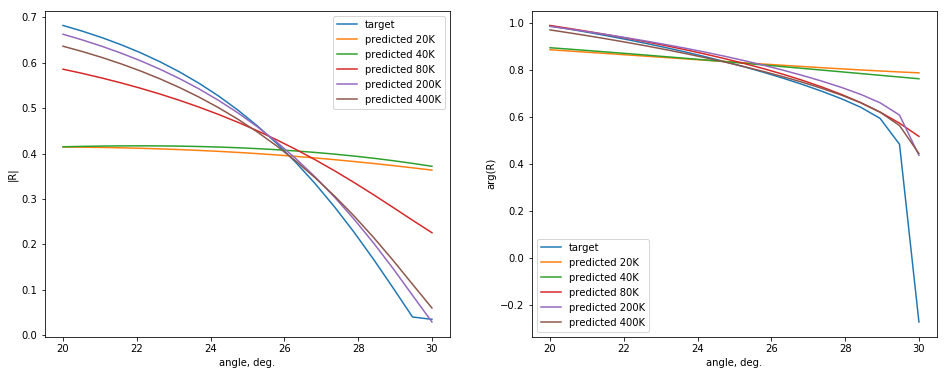

Sample number: 20384


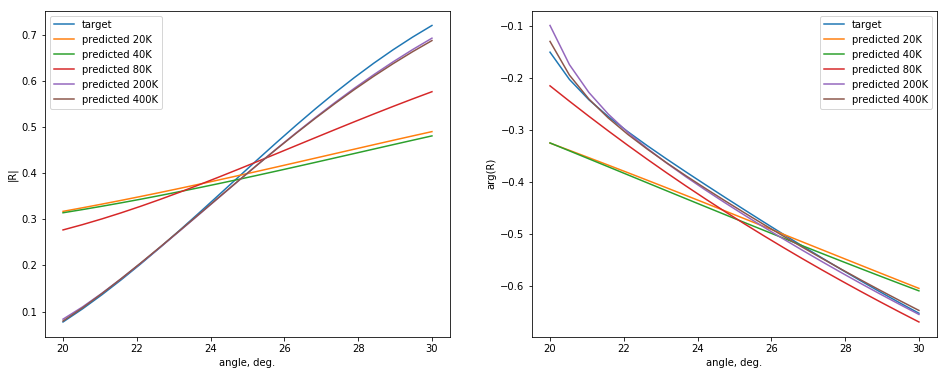

Sample number: 29351


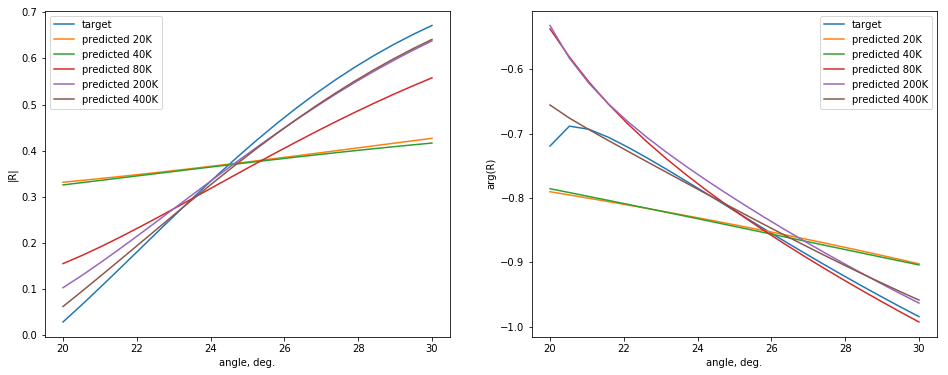

Sample number: 3967


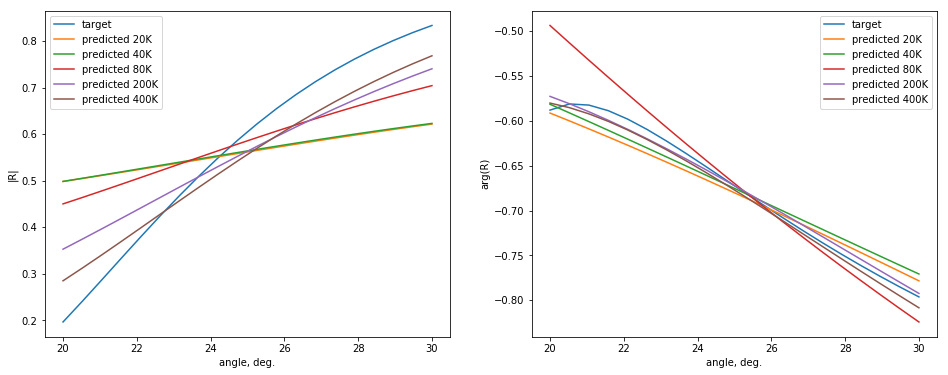

Sample number: 15669


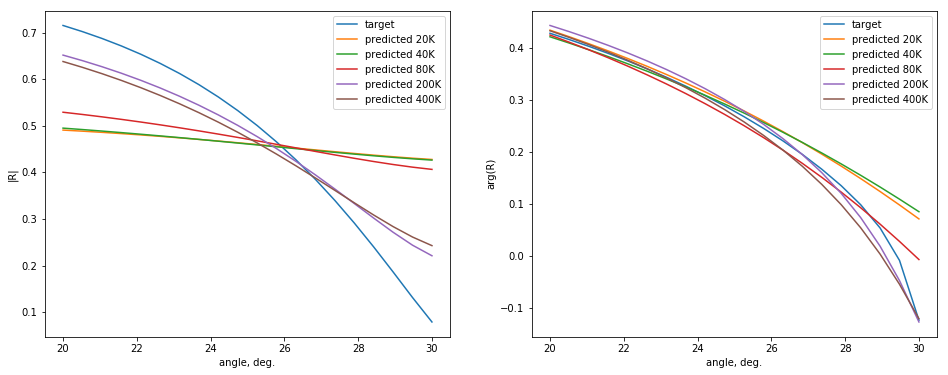

Sample number: 15390


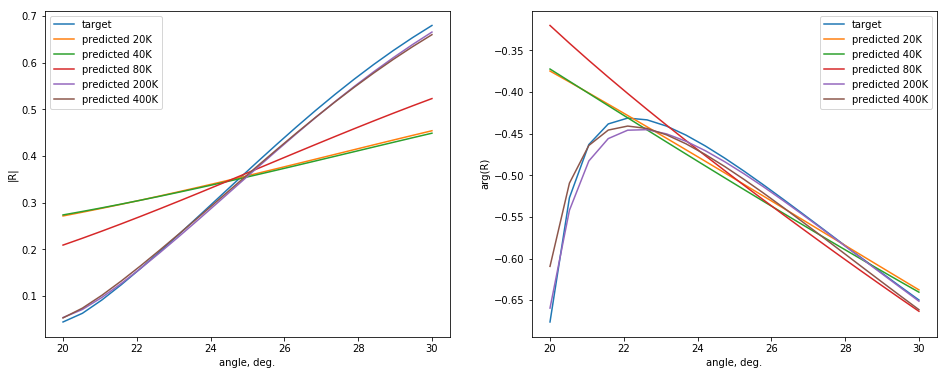

Sample number: 24747


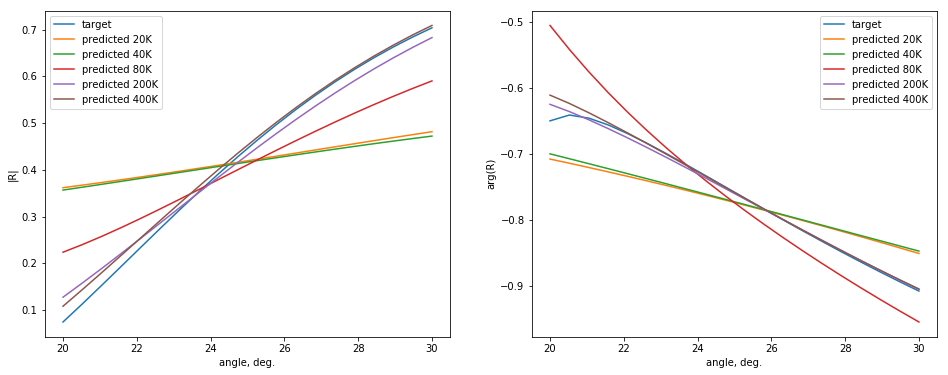

Sample number: 13680


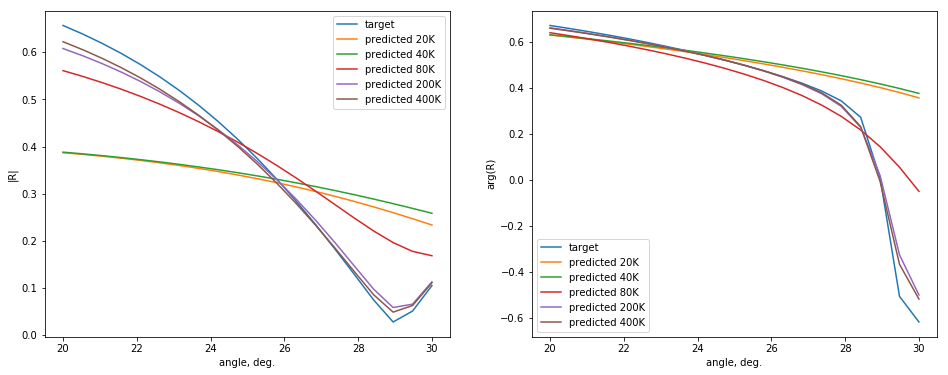

Sample number: 6053


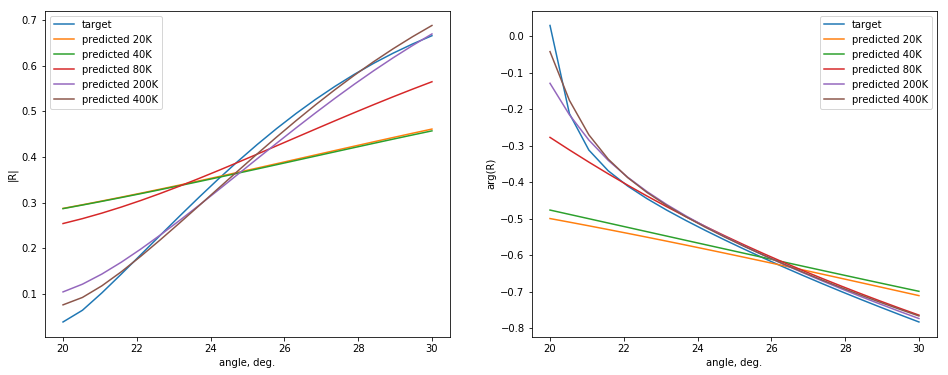

Sample number: 24842


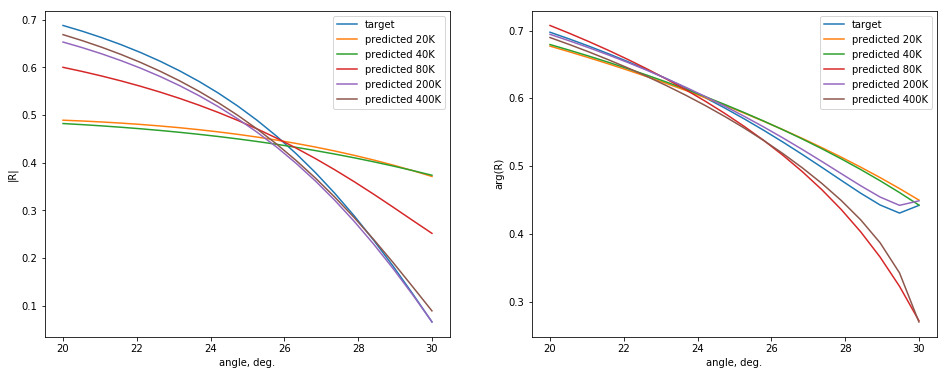

Sample number: 9934


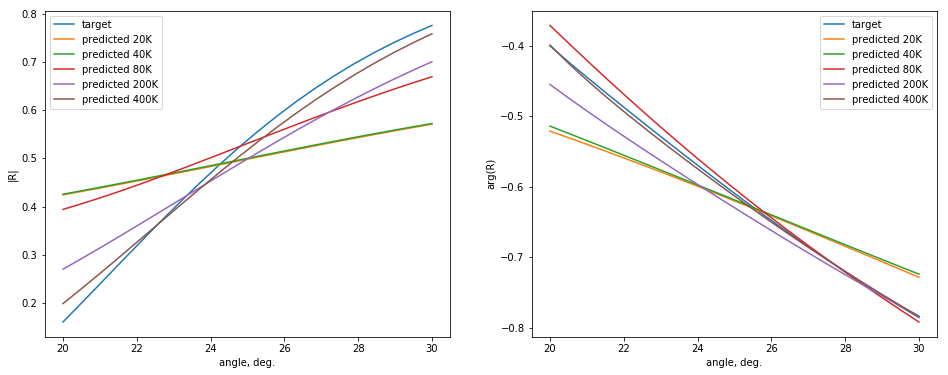

Sample number: 29979


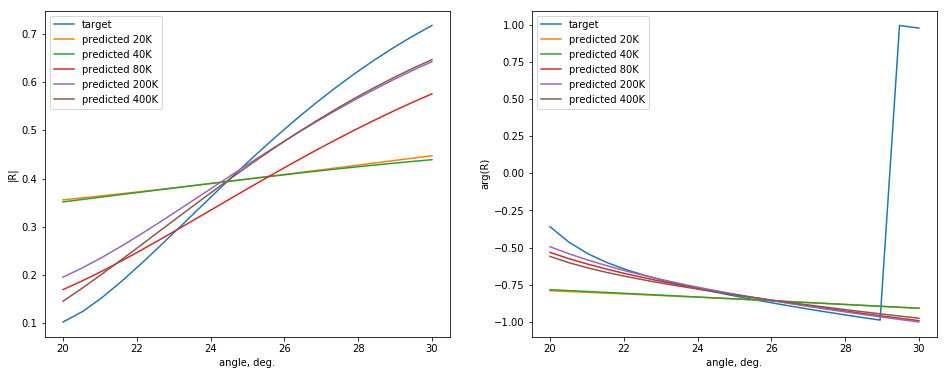

Sample number: 29796


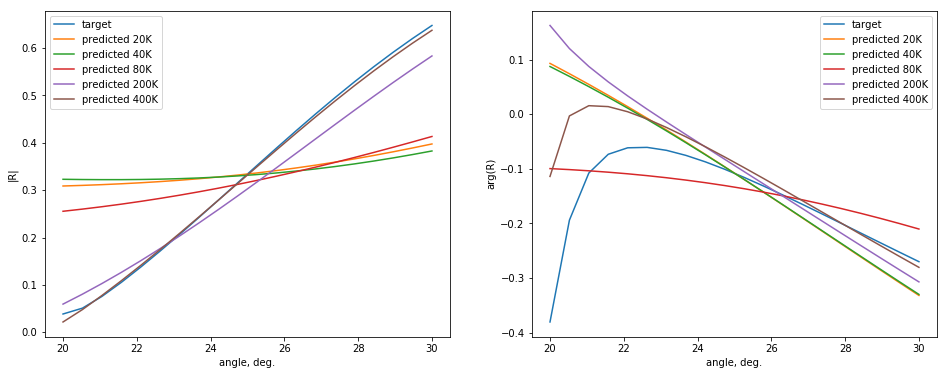

In [33]:
n_largest=20
#fig=plt.figure(figsize=(16, 40))

for i,number in enumerate(indices_of_largest[:n_largest]):
    print("Sample number:", number)
    fig=plt.figure(figsize=(16, 6))
    #plt.subplot(n_largest,2,i*2+1)
    plt.subplot(1,2,1)
    plt.plot(angles, np.sqrt(refl[number,:points]**2+refl[number,points:]**2), label="target")
    plt.plot(angles, np.sqrt(r_20K[number,:points]**2+r_20K[number,points:]**2), label="predicted 20K")
    plt.plot(angles, np.sqrt(r_40K[number,:points]**2+r_40K[number,points:]**2), label="predicted 40K")
    plt.plot(angles, np.sqrt(r_80K[number,:points]**2+r_80K[number,points:]**2), label="predicted 80K")
    plt.plot(angles, np.sqrt(r_200K[number,:points]**2+r_200K[number,points:]**2), label="predicted 200K")
    plt.plot(angles, np.sqrt(r_400K[number,:points]**2+r_400K[number,points:]**2), label="predicted 400K")
    plt.xlabel("angle, deg.")
    plt.ylabel("|R|")
    #plt.ylim(bottom=0, top=1)
    plt.legend()

    #plt.subplot(n_largest,2,i*2+2)
    plt.subplot(1,2,2)
    plt.plot(angles, np.arctan2(refl[number,points:],refl[number,:points])/np.pi, label="target")
    plt.plot(angles, np.arctan2(r_20K[number,points:],r_20K[number,:points])/np.pi, label="predicted 20K")
    plt.plot(angles, np.arctan2(r_40K[number,points:],r_40K[number,:points])/np.pi, label="predicted 40K")
    plt.plot(angles, np.arctan2(r_80K[number,points:],r_80K[number,:points])/np.pi, label="predicted 80K")
    plt.plot(angles, np.arctan2(r_200K[number,points:],r_200K[number,:points])/np.pi, label="predicted 200K")
    plt.plot(angles, np.arctan2(r_400K[number,points:],r_400K[number,:points])/np.pi, label="predicted 400K")
    plt.xlabel("angle, deg.")
    plt.ylabel("arg(R)")
    plt.legend()
    plt.show()

In [40]:
thick_400K[13680]

array([233.48608, 119.31268, 133.44199, 146.59383, 244.1618 , 207.20538,
       249.10141, 107.34203, 155.90453, 139.96555, 322.48148,  82.36803],
      dtype=float32)

In [41]:
thicknes[13680]

array([296,  67, 338, 325, 224, 218, 339, 122, 101,  40, 246, 247])

# Close spectrum

In [66]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

In [67]:
n1=0
n2=10000
R_dist_mat = squareform(pdist(refl_test[n1:n2], metric="euclidean"))
real_thickness_dist_mat = squareform(pdist(test_structures[n1:n2], metric="euclidean"))
pred_thickness_dist_mat = squareform(pdist(thick_pred[n1:n2], metric="euclidean"))

In [68]:
pearsonr(R_dist_mat.flatten(),real_thickness_dist_mat.flatten())

(-0.058222509797174665, 0.0)

In [69]:
pearsonr(R_dist_mat.flatten(),pred_thickness_dist_mat.flatten())

(0.4783196844234786, 0.0)

In [71]:
np.fill_diagonal(R_dist_mat, np.nan)

In [72]:
mins=np.nanmin(R_dist_mat, axis=1)

In [73]:
mins_sorted=np.sort(mins)
print(mins_sorted)

[0.1115564  0.1115564  0.11737913 ... 1.91563963 1.9653268  2.0604858 ]


In [75]:
i, j = np.where(R_dist_mat == mins_sorted[6])

In [76]:
print(i,j)

[4621 7525] [7525 4621]


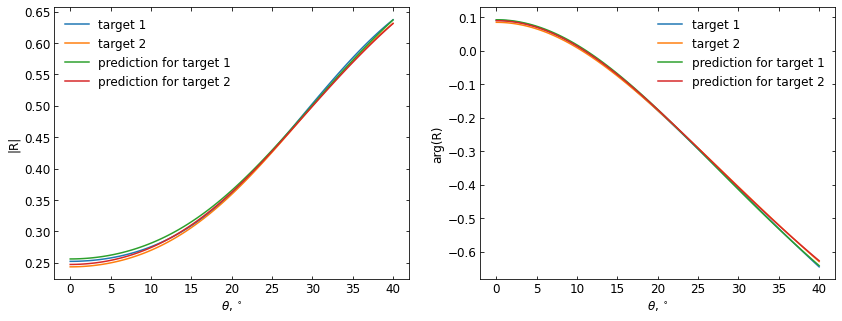

In [81]:
number1=n1+i[0]
number2=n1+i[1]
#number1=2314
#number2=4460
fig=plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_test[number1,:points]**2+refl_test[number1,points:]**2), label="target 1")
plt.plot(angles, np.sqrt(refl_test[number2,:points]**2+refl_test[number2,points:]**2), label="target 2")
plt.plot(angles, np.sqrt(refl_pred[number1,:points]**2+refl_pred[number1,points:]**2), label="prediction for target 1")
plt.plot(angles, np.sqrt(refl_pred[number2,:points]**2+refl_pred[number2,points:]**2), label="prediction for target 2")
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("|R|",fontsize=fontsize)
#plt.ylim(bottom=0, top=1)
plt.legend(frameon=False,fontsize=fontsize)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_test[number1,points:],refl_test[number1,:points])/np.pi, label="target 1")
plt.plot(angles, np.arctan2(refl_test[number2,points:],refl_test[number2,:points])/np.pi, label="target 2")
plt.plot(angles, np.arctan2(refl_pred[number1,points:],refl_pred[number1,:points])/np.pi, label="prediction for target 1")
plt.plot(angles, np.arctan2(refl_pred[number2,points:],refl_pred[number2,:points])/np.pi, label="prediction for target 2")
plt.xlabel(r"$\theta$, $^{\circ}$",fontsize=fontsize)
plt.ylabel("arg(R)",fontsize=fontsize)
plt.legend(frameon=False,fontsize=fontsize)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize, top=True, right=True)
plt.savefig(directory+file+'_sim_spectra.png', dpi=400, bbox_inches='tight')

In [78]:
print(thick_pred[number1])
print(thick_pred[number2])
print(test_structures[number1])
print(test_structures[number2])

[130.0716  213.9315  196.92778 140.897   196.4498  191.54538 211.97293
 120.65487 217.83206 182.6505 ]
[124.22746 219.67133 200.73117 141.01836 191.79742 189.11249 215.63043
 119.86762 222.6368  181.37415]
[117. 259. 326. 260.  89.  75. 103.  84. 220. 166.]
[147.  37. 173. 222.  61. 213.   4. 209. 182. 121.]


In [79]:
np.mean(np.abs(thick_pred[number1]-thick_pred[number2]))

3.3119798

In [80]:
np.mean(np.abs(test_structures[number1]-test_structures[number2]))

91.6

In [119]:
def draw_multilayer(ax,thicknesses,left=0):
    ax.add_patch(Rectangle((left,-0.5),width=0.5, height=0.5, linestyle='--', color='tab:blue', alpha=0.4))
    current_coord=0
    for ind,d in enumerate(thicknesses):
        if ind%2==0:
            ax.add_patch(Rectangle((left,current_coord),width=0.5, height=d, linestyle='--', color='tab:green', alpha=0.25))
        else:
            ax.add_patch(Rectangle((left,current_coord),width=0.5, height=d, linestyle='--', color='tab:blue', alpha=0.15))
        current_coord+=d
    #ax.add_patch(Rectangle((N_layers*(d1+d2),0),width=add_layer, height=rectangles_height, linestyle='--', color='tab:blue', alpha=0.15))

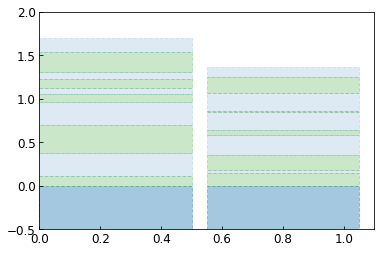

In [125]:
ax=plt.gca()
#draw_multilayer(ax,thick_pred[number1]/1000)
#draw_multilayer(ax,thick_pred[number2]/1000, left=0.6)

draw_multilayer(ax,test_structures[number1]/1000)
draw_multilayer(ax,test_structures[number2]/1000, left=0.55)
plt.ylim(top=2, bottom=-0.5)
plt.xlim(right=1.1)
plt.gca().tick_params(axis='both', direction='in', labelsize=fontsize)
plt.savefig(directory+file+'_test_thickness.svg')

In [162]:
R_dist=pdist(refl[:5000], metric="euclidean")

In [163]:
#d_dist=pdist(thick_400K[:1000], metric="euclidean")
d_dist=pdist(thick_400K[:5000], lambda u, v: np.mean(np.abs(u-v)))

In [95]:
thick_400K.shape

(40000, 12)

In [96]:
refl.shape

(40000, 40)

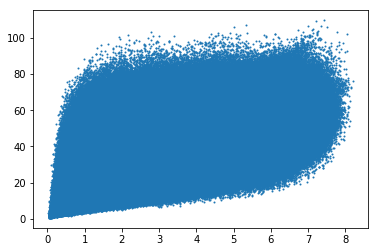

In [164]:
plt.scatter(R_dist,d_dist,s=1)

In [107]:
R_dist

array([2.43114157, 2.27491243, 1.42186181, ..., 5.20598786, 5.00906082,
       1.94812135])

In [141]:
np.argwhere(d_dist == (d_dist[R_dist<0.5]).max())

array([[256092]], dtype=int64)

In [125]:
am=999
ind_array=np.zeros((int(am*(am+1)/2),2))

In [133]:
ind=0
for ind1 in range(1000):
    for ind2 in range(ind1):
        ind_array[ind]=[ind2,ind1]
        ind+=1

In [122]:
d_dist.size

499500

In [142]:
ind_array[256092]

array([122., 716.])

In [144]:
d_dist[256092]

59.8678092956543

In [147]:
np.sqrt(((refl[number1]-refl[number2])**2).sum())

5.085268992674544

In [166]:
dist_mat = squareform(pdist(refl[:5000], metric="euclidean"))

In [167]:
d_dist_mat=squareform(d_dist)

In [168]:
np.argwhere(d_dist_mat==(d_dist_mat[dist_mat<0.1]).max())

array([[2314, 4460],
       [4460, 2314]], dtype=int64)

In [169]:
d_dist_mat[2314,4460]

29.890731811523438

# Differentiator

In [137]:
angle_center=10
angle_min=0
angle_max=40
amplitude=0.3
angles=np.linspace(angle_min,angle_max,points)
alpha=amplitude/sin((angle_max-angle_center)*np.pi/180)
diff_transfer_matrix=alpha*1j*np.sin((angles-angle_center)*np.pi/180)
refl_diff=np.zeros((2*points),dtype=float)
refl_diff[:points]=np.real(diff_transfer_matrix)
refl_diff[points:]=np.imag(diff_transfer_matrix)

In [138]:
diff_spectrum=torch.tensor(refl_diff[None,:],device=torch.device('cpu'),dtype=torch.float32)
thick=model(diff_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(n_structure,wl=wl, angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((2*points),dtype=float)
r[:points]=np.real(total_matrix)
r[points:]=np.imag(total_matrix)

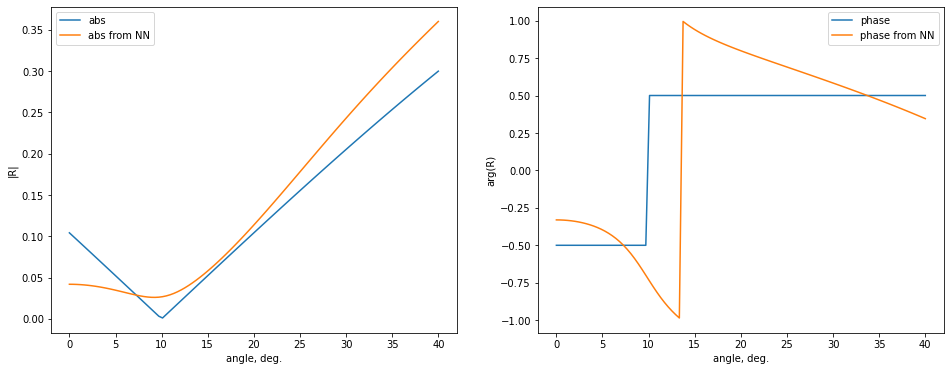

In [139]:
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_diff[:points]**2+refl_diff[points:]**2), label="abs")
plt.plot(angles, np.sqrt(r[:points]**2+r[points:]**2), label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_diff[points:],refl_diff[:points])/np.pi, label="phase")
plt.plot(angles, np.arctan2(r[points:],r[:points])/np.pi, label="phase from NN")
plt.xlabel("angle, deg.")
plt.ylabel("arg(R)")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()

# Arbitrary spectrum design

In [203]:
refl_arb=np.zeros((2*points),dtype=float)
center=20
width=10
function=np.e**(-((angles-center)/width)**2)
refl_arb[:points]=function
refl_arb[points:]=0

In [204]:
target_spectrum=torch.tensor(refl_arb[None,:],device=torch.device('cpu'),dtype=torch.float32)
thick=model(target_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(n_structure, wl=wl,angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((2*points),dtype=float)
r[:points]=np.real(total_matrix)
r[points:]=np.imag(total_matrix)

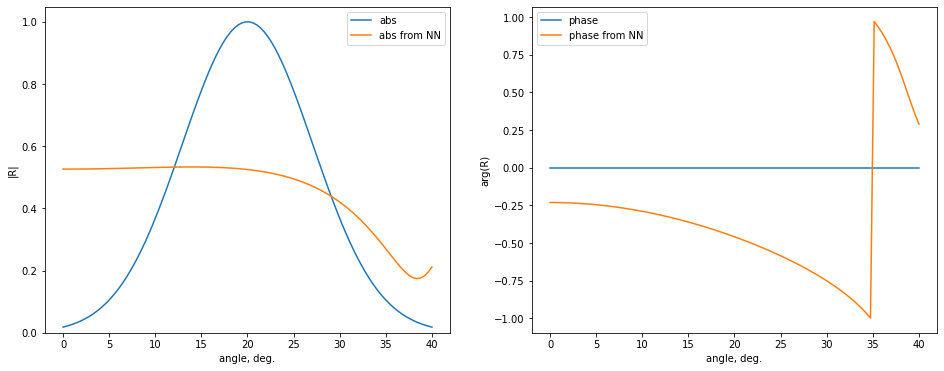

In [205]:
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_arb[:points]**2+refl_arb[points:]**2), label="abs")
plt.plot(angles, np.sqrt(r[:points]**2+r[points:]**2), label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_arb[points:],refl_arb[:points])/np.pi, label="phase")
plt.plot(angles, np.arctan2(r[points:],r[:points])/np.pi, label="phase from NN")
plt.xlabel("angle, deg.")
plt.ylabel("arg(R)")
plt.legend()

# Phase sweep

In [206]:
no_points=2000
refl_sweep=np.zeros((no_points,2*points),dtype=float)
ph=np.linspace(-np.pi,np.pi,no_points)
for i,r_phase in enumerate(ph):
    refl_sweep[i,:points]=np.cos(r_phase)*function
    refl_sweep[i,points:]=np.sin(r_phase)*function

In [207]:
target_spectrum=torch.tensor(refl_sweep,device=torch.device('cpu'),dtype=torch.float32)
thick=model(target_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(n_structure, wl=wl,angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((no_points,2*points),dtype=float)
r[:,:points]=np.real(total_matrix)
r[:,points:]=np.imag(total_matrix)

In [208]:
MSE_error=np.mean((refl_sweep-r)**2,axis=1)

Min MSE = 0.04928515591488782 at phi=0.8539269634817408 pi


Text(0, 0.5, 'MSE')

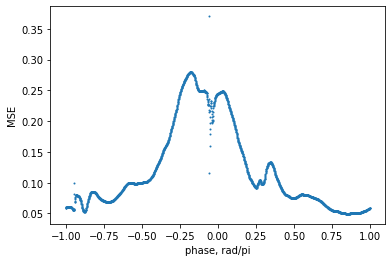

In [212]:
plt.scatter(ph/np.pi,MSE_error,s=1)
print(f'Min MSE = {MSE_error.min()} at phi={ph[np.argmin(MSE_error)]/np.pi} pi')
plt.xlabel("phase, rad/pi")
plt.ylabel("MSE")

# Arbitrary specrum abs

In [61]:
refl_arb=np.zeros((points),dtype=float)
refl_arb[:]=1

In [63]:
target_spectrum=torch.tensor(refl_arb[None,:],device=torch.device('cpu'),dtype=torch.float32)
thick=model(target_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((points),dtype=float)
r=np.abs(total_matrix)

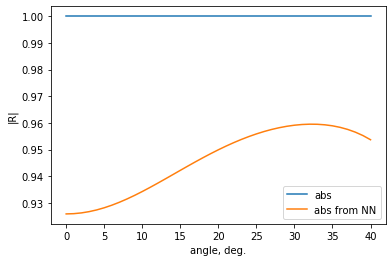

In [68]:
plt.plot(angles, refl_arb, label="abs")
plt.plot(angles, r[0], label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
#plt.ylim(bottom=0)
plt.legend()

In [66]:
r[0]

array([0.92589125, 0.92598612, 0.92626927, 0.92673641, 0.92738051,
       0.92819202, 0.92915909, 0.93026791, 0.93150307, 0.93284789,
       0.93428488, 0.93579605, 0.93736329, 0.93896874, 0.94059504,
       0.94222558, 0.94384471, 0.94543785, 0.94699162, 0.94849385,
       0.94993356, 0.95130093, 0.95258722, 0.95378464, 0.95488621,
       0.95588558, 0.9567769 , 0.95755456, 0.95821303, 0.9587466 ,
       0.95914915, 0.95941393, 0.95953319, 0.95949793, 0.95929752,
       0.95891928, 0.95834798, 0.95756529, 0.95654904, 0.95527241,
       0.95370284])

# load R

In [216]:
test_R_structure=np.char.replace(np.loadtxt("test/test_struct.txt", dtype=str),'i','j').astype(complex)

In [217]:
refl_arb=np.zeros((2*points),dtype=float)
refl_arb[:points]=np.real(test_R_structure)
refl_arb[points:]=np.imag(test_R_structure)

In [220]:
target_spectrum=torch.tensor(refl_arb[None,:],device=torch.device('cpu'),dtype=torch.float32)
thick=model(target_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(n_structure, wl=wl,angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/800)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((2*points),dtype=float)
r[:points]=np.real(total_matrix)
r[points:]=np.imag(total_matrix)

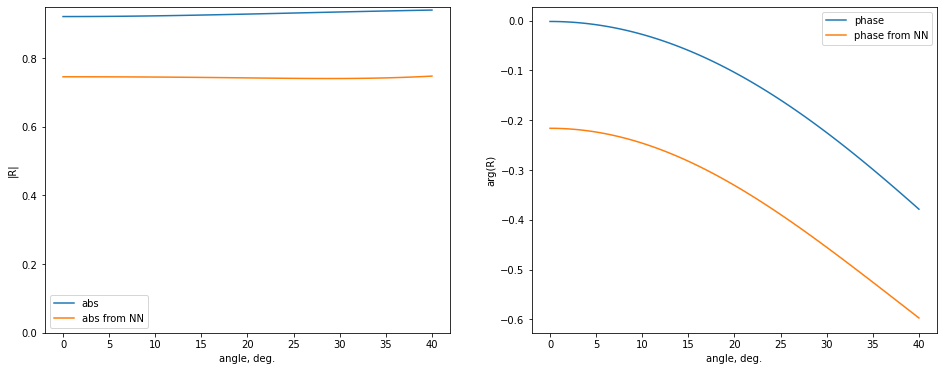

In [221]:
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_arb[:points]**2+refl_arb[points:]**2), label="abs")
plt.plot(angles, np.sqrt(r[:points]**2+r[points:]**2), label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_arb[points:],refl_arb[:points])/np.pi, label="phase")
plt.plot(angles, np.arctan2(r[points:],r[:points])/np.pi, label="phase from NN")
plt.xlabel("angle, deg.")
plt.ylabel("arg(R)")
plt.legend()